In [1]:
%matplotlib widget

In [2]:
import tifffile as tf
import os
import numpy as np
import scipy
from matplotlib import pyplot as plt
from neurom.io.utils import load_morphology
from neurom import viewer

from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from fury import actor, window
from IPython.core.display import Image


In [3]:
CF1 = '/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Image Stacks/CF_1'
CF1_label = '/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc'

# load image stack
cf1_files = os.listdir(CF1)
cf1_stack = []
for i in range(len(cf1_files)):
    cf1_stack.append(tf.imread(os.path.join(CF1,cf1_files[i])))
cf1_stack = np.array(cf1_stack)
print(f'stack shape: {cf1_stack.shape}')

# load gold standard
label = load_morphology(CF1_label)

stack shape: (34, 4343, 6120, 3)



/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1506:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1493:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1322:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1216:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1118:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:0:warning


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'Figure'}, xlabel='X', ylabel='Y', zlabel='Z'>)

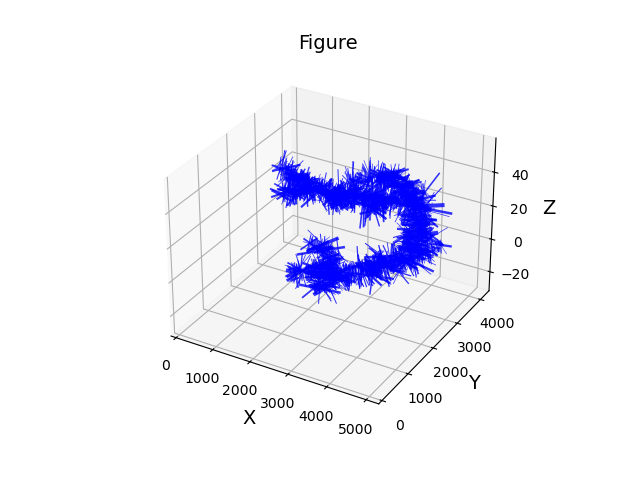

In [4]:
viewer.draw(label.neurites[0], mode='3d')

In [5]:
points = label.points[:,:3].astype(int)
points = np.stack((points[:,2], points[:,1]//10, points[:,0]//10))
print(points.shape)

(3, 2109)


In [197]:
def gaussian_kernel(u, sigma):
    g = np.exp(-0.5 * (u / sigma)**2)
    return g

def distance(shape, dx):
    x = [(np.arange(x)-(x-1)/2)*dx[i] for i,x in enumerate(shape)]
    X = np.stack(np.meshgrid(*x, indexing='ij'), axis=0)
    d = np.sqrt((X**2).sum(axis=0))
    return d

In [198]:
shape = (5,5)
d = distance(shape, dx=[2,1,1])
g = gaussian_kernel(d, 1.0)


In [199]:
g

array([[4.53999298e-05, 2.03468369e-04, 3.35462628e-04, 2.03468369e-04,
        4.53999298e-05],
       [1.83156389e-02, 8.20849986e-02, 1.35335283e-01, 8.20849986e-02,
        1.83156389e-02],
       [1.35335283e-01, 6.06530660e-01, 1.00000000e+00, 6.06530660e-01,
        1.35335283e-01],
       [1.83156389e-02, 8.20849986e-02, 1.35335283e-01, 8.20849986e-02,
        1.83156389e-02],
       [4.53999298e-05, 2.03468369e-04, 3.35462628e-04, 2.03468369e-04,
        4.53999298e-05]])

In [6]:
density = np.zeros((cf1_stack.shape[0],cf1_stack.shape[1]//10, cf1_stack.shape[2]//10))
density[*points] = 1.0
density = scipy.ndimage.gaussian_filter(density, sigma=2)
density = density / density.max()
mask = np.zeros_like(density)
mask[density>0.04] = 1.0

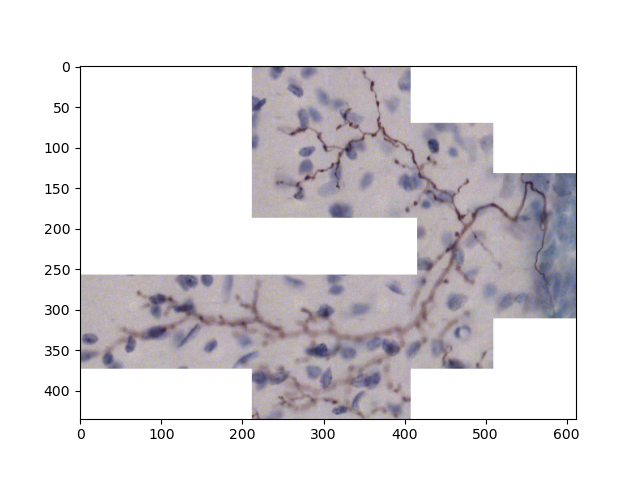

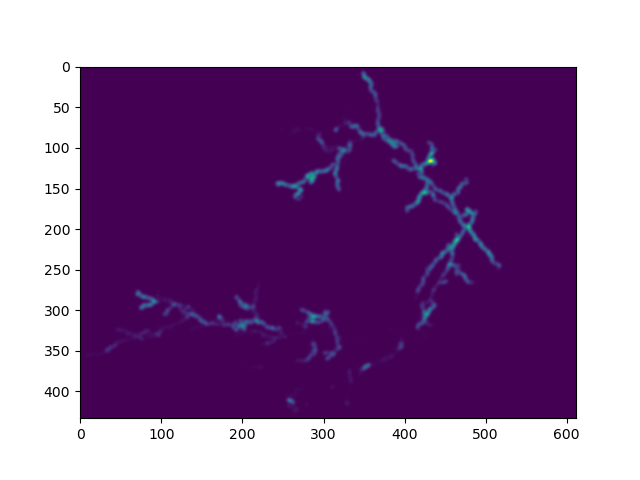

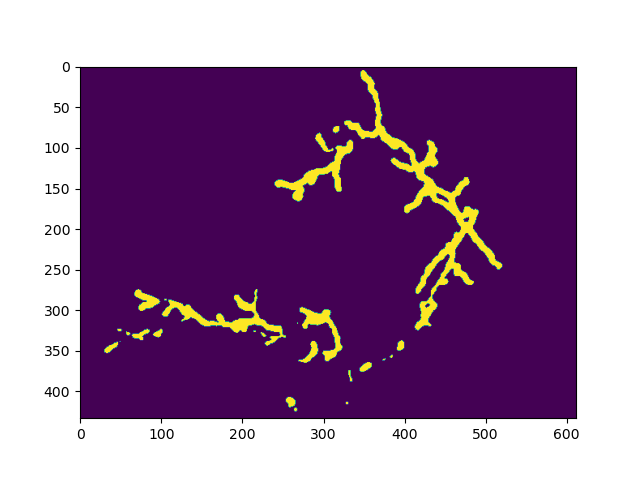

In [8]:
i = 19
img = cf1_stack[i, ::10, ::10]
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(density[i])
plt.figure()
plt.imshow(mask[i])


In [47]:
np.savez('/home/brysongray/tractography/data/cerebellar_climbing_fibers_cf1_test',density=density,mask=mask, seed=(19,180,488), dx=(0.88,1.0,1.0))

In [57]:
# sample unit vectors evenly on a hemisphere
n_pts = 25
bvalue = 1000
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial,5000)
vertices = hsph_updated.vertices
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

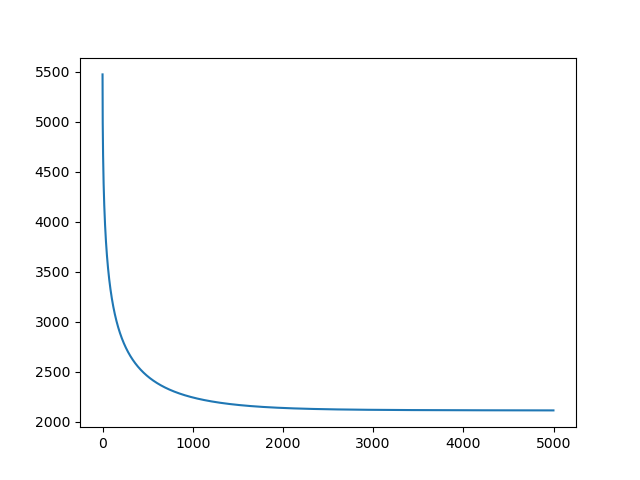

In [58]:
plt.figure()
plt.plot(potential)

In [59]:
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile

In [60]:
image = screenshot_gradients(sph_gtab, title='Example directions', )
Image(filename=image)

/home/brysongray/anaconda3/envs/tractography/lib/python3.11/site-packages/vtkmodules/util/numpy_support.py:74: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [18]:
f = '/home/brysongray/tractography/neuron_trx/action_space_60_dir.npy'
ACTIONS = np.load(f)
print(ACTIONS.shape)
ACTIONS = np.concatenate((ACTIONS, np.zeros((1,3))))
print(ACTIONS.shape)
# np.save(f, ACTIONS)

(60, 3)
(61, 3)


In [60]:
import torch

In [104]:
def crop(img, center, radius):
    """ Crop an image around a center point (rounded to the nearest pixel center).
        The cropped image will be smaller than the given radius if it overlaps with the image boundary.

        Parameters
        ----------
        img : ndarray
            3d image to be cropped.
        center : list or tuple
            The center of the cropped image in slice-row-col coordinates. This will be rounded to the nearest pixel index.
        radius : int
            The radius of the cropped image. The total width is 2*radius + 1  in each dimension assuming it doesn't intersect with a boundary.
        
        Returns
        -------
        cropped_img :  ndarray
            3d cropped image
        padding : ndarray
            1d array of six integers specifying the distance in pixels that the cropped image overlaps with boundaries,
            two for each dimension, the first being the overlap with the smallest image index and the second with the largest index.
    """
    i,j,k = np.round(center)
    shape = img.shape
    zpad_top = zpad_btm = ypad_front = ypad_back = xpad_left = xpad_right = 0

    if (i + radius) > shape[0]-1:
        zpad_btm = i + radius - (shape[0]-1)
    if (i - radius) < 0:
        zpad_top = radius - i
    if (j + radius) > shape[1]-1: # back is the max y idx
        ypad_back = j + radius - (shape[1]-1) # number of zeros to append in the y dim
    if (j - radius) < 0: # front is zeroth idx
        ypad_front = radius - j
    if (k + radius) > shape[2]-1:
        xpad_right = k + radius - (shape[2]-1) # number of zeros to append in the x dim
    if (k - radius) < 0:
        xpad_left = radius - k
    
    padding = np.array([zpad_top, zpad_btm, ypad_front, ypad_back, xpad_left, xpad_right])
    zrmd_btm, zrmd_top, yrmd_front, yrmd_back, xrmd_left, xrmd_right = np.array([radius]*6) - padding
    
    cropped_img = img[i-zrmd_top:i+zrmd_btm+1, j-yrmd_front:j+yrmd_back+1, k-xrmd_left:k+xrmd_right+1] # slicing img creates a view (not a copy of img)

    return cropped_img, padding

def add_bundle_point(img, point, ball):
    """ Add a blurred point (ball) to an image.

        This is done in-place to avoid copying arrays.
    
        Parameters
        ----------
        img : torch.Tensor
            3d bundle image array
        point : list or tuple
            The point to add in slice-row-col coordiates. This will be rounded to the nearest int.
        ball : ndarray
            Blurred point to add to img.
            
    """
    p = np.round(point)
    shape = ball.shape
    radius = (shape[0] - 1)//2
    patch, padding = crop(img, p, radius) # patch is a cropped view of the original array
    zpad_top, zpad_btm, ypad_front, ypad_back, xpad_left, xpad_right = padding
    # The in-place addition to patch changes the original bundle_density array since patch is a view
    patch += torch.Tensor(ball[zpad_top:shape[0] - zpad_btm, ypad_front:shape[1] - ypad_back, xpad_left:shape[2] - xpad_right])

    return

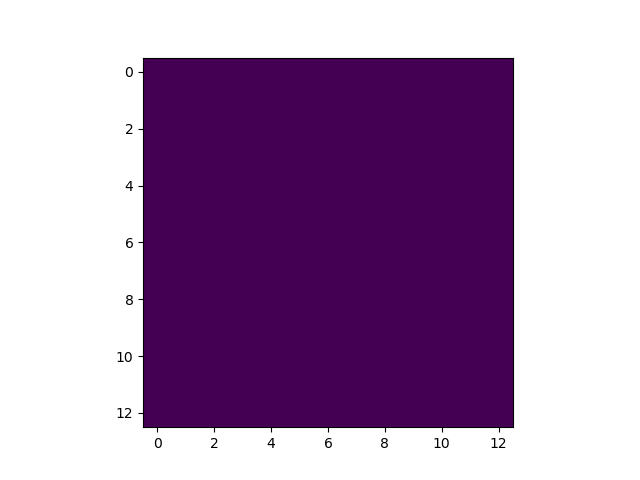

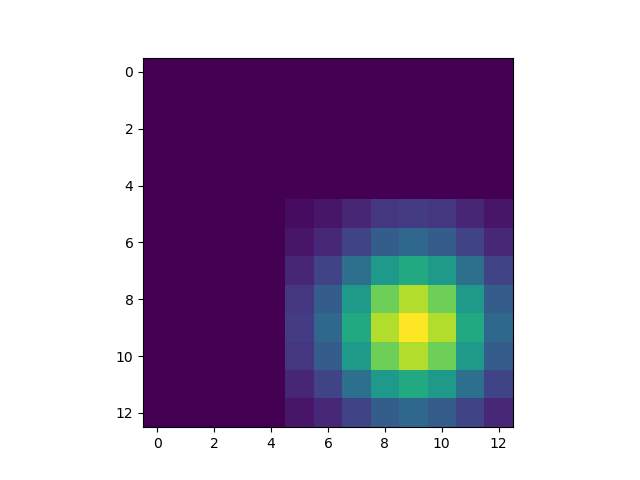

In [106]:
RADIUS = 4 # radius of the gaussian kernel
WIDTH = 2*RADIUS + 1
spike = np.zeros((WIDTH,WIDTH,WIDTH))
spike[RADIUS,RADIUS,RADIUS] = 1.0
BLOB = scipy.ndimage.gaussian_filter(spike, sigma=2)

img = torch.zeros((13,13,13))
point = [6,9,9]

plt.figure()
plt.imshow(img[6])
add_bundle_point(img, point, BLOB)
plt.figure()
plt.imshow(img[6])

In [109]:
class Environment():
    """ Loads a volume. Takes a list of seeds which
    which will be cycled through on every call of reset.

    Parameters
    ----------
    img : torch.Tensor
        Tensor with shape c x h x w x d
    radius : int
        The radius of a state input image patch in along each axis (total width is 2*radius + 1).
    seeds : ndarray
        N x 3 array of starting streamline coordinates
    mask : torch.Tensor
        Tensor  with shape 1 x h x w x d
    true_denstiy : torch.Tensor
        Tensor with shape 1 x h x w x d
    actions : ndarray
        N x 3 array of possible step directions.
    step_size : float
        Distance taken in each step in units of pixels.

    """

    def __init__(self, img, radius, seeds, mask, true_density, actions, step_size=1.0):

        self.head_id = 0
        self.img = img
        self.radius = radius
        self.mask = mask
        self.true_density = true_density
        self.step_size = step_size
        self.paths = torch.Tensor(seeds[None]) # an 1 x N x 3 array. First axis is time step.
        self.cos_path_angle = torch.ones((1, len(self.paths))) # 1 x N array.       
        self.action_space = actions # N x 3 array
        self.count = 0 # count number of resets
        
        # initialize bundle density map
        bundle_density = torch.zeros(true_density.shape)
        for i in range(self.paths.shape[1]):
            add_bundle_point(bundle_density, self.paths[0,i].item(), BALL)
        self.img = torch.cat((self.img, bundle_density), dim=0)

        # initialize last two step directions randomly for each streamline
        g = torch.Generator()
        g.manual_seed(count)
        last_steps = torch.rand(*self.paths.shape, generator=g)
        last_steps = last_steps / np.sqrt(last_steps[0, :, 0]**2 + last_steps[0, :, 1]**2 + last_steps[0, :, 2]**2)
        last_steps = np.stack((last_steps, last_steps), axis=0)
        self.paths = np.stack((self.paths - last_steps[0]*2, self.paths - last_steps[1], self.paths), axis=0)

TypeError: 'tuple' object does not support item assignment

In [ ]:
img = torch.zeros((13,13,13))
radius = 

In [2]:
import numpy as np
import scipy

In [5]:
x = np.array([0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0])
print(x)
y = scipy.ndimage.gaussian_filter(x, 1)
print(y)
print(y.sum())

[0. 0. 0. 3. 0. 0. 0. 0.]
[1.36970767e-02 1.61973382e-01 7.25914337e-01 1.19683041e+00
 7.25914337e-01 1.61973382e-01 1.32955849e-02 4.01491874e-04]
3.0
